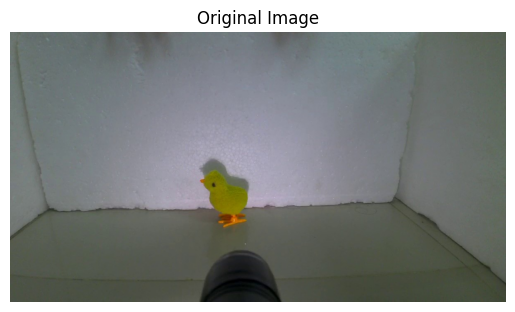

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------- โหลดและแสดงภาพต้นฉบับ ----------------
img = cv2.imread("Chicken.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

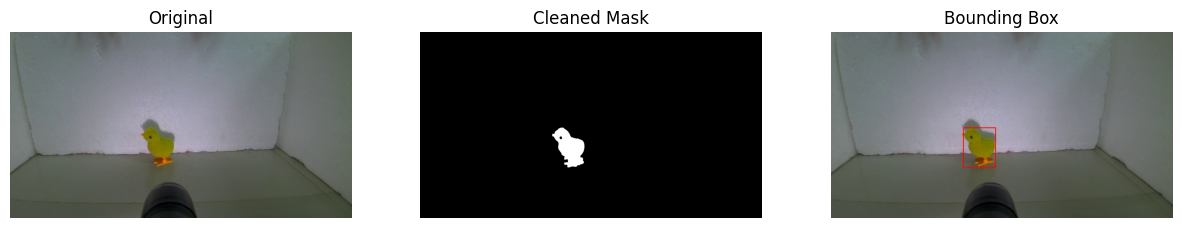

In [ ]:
# ---------------- แปลงเป็น HSV ----------------
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# ช่วงสีส้มถึงเหลือง
lower_orange_yellow = np.array([5, 100, 100])
upper_orange_yellow = np.array([35, 255, 255])


# สร้าง mask
mask = cv2.inRange(hsv, lower_orange_yellow, upper_orange_yellow)

# ---------------- ทำความสะอาด mask ----------------
kernel = np.ones((6,6), np.uint8)

# ลบ noise จุดเล็ก ๆ
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# ปิดรูว่างเล็ก ๆ ภายในวัตถุ
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

# ---------------- ใช้ mask กับภาพ ----------------
res_clean = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_clean)

plt.figure(figsize=(15,5))
plt.subplot(1,3,2); plt.imshow(mask_clean, cmap="gray"); plt.title("Cleaned Mask"); plt.axis("off")
plt.show()


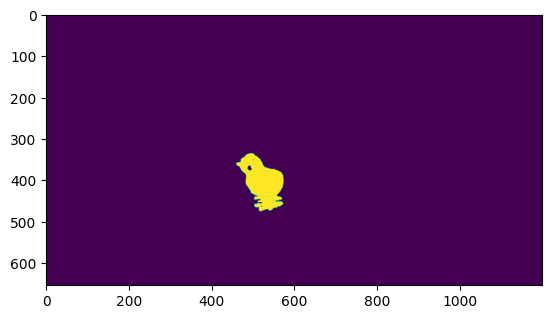

In [2]:
plt.imshow(mask)

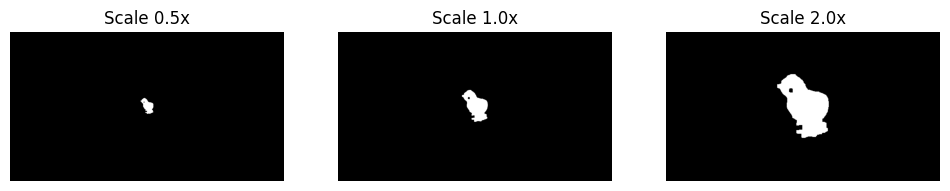

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# โหลดภาพต้นฉบับ
img = mask_clean

# หา bounding box ของวัตถุสีขาว
x,y,w,h = cv2.boundingRect(img)

# ตัดเฉพาะส่วนวัตถุ (mask)
object_crop = img[y:y+h, x:x+w]

# ขนาด scaling ที่ต้องการ (เล็ก กลาง ใหญ่)
scales = [0.5, 1.0, 2.0]  

results = []

for s in scales:
    # resize วัตถุ
    new_w, new_h = int(w*s), int(h*s)
    resized_obj = cv2.resize(object_crop, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # สร้าง canvas ดำขนาดเท่าเดิม
    canvas = np.zeros_like(img)

    # คำนวณตำแหน่งวางให้อยู่กลางภาพ
    start_x = (canvas.shape[1] - new_w)//2
    start_y = (canvas.shape[0] - new_h)//2

    # วาง object ลงบน canvas
    canvas[start_y:start_y+new_h, start_x:start_x+new_w] = resized_obj

    results.append(canvas)

# แสดงผล
fig, axes = plt.subplots(1, len(results), figsize=(12,4))
for ax, s, r in zip(axes, scales, results):
    ax.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Scale {s}x")
    ax.axis("off")
plt.show()

# บันทึกไฟล์
for s, r in zip(scales, results):
    cv2.imwrite(f"chicken{s}x.png", r)


In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- 1. โหลดรูปภาพ ---

try:
    # โหลดรูปภาพ Original ที่ต้องการค้นหา (ในรูปแบบ Grayscale)
    original_image = cv2.imread('Chicken.jpg', cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        raise FileNotFoundError("ไม่พบไฟล์รูปภาพ Original 'Chicken Edit 1.png'")

    # สร้างเวอร์ชันสีของรูป Original ไว้สำหรับวาด Bounding Box
    original_image_color = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
except FileNotFoundError as e:
    print(e)
    exit()

# รายชื่อไฟล์ของ Template ทั้งหมด
template_files = ['chicken0.5x.png', 'chicken1.0x.png', 'chicken2.0x.png']
template_results = []

for filename in template_files:
    try:
        # โหลด Template ปัจจุบัน (ในรูปแบบ Grayscale)
        template = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if template is None:
            print(f"คำเตือน: ไม่พบไฟล์ Template '{filename}' จะข้ามไฟล์นี้ไป")
            continue

        # หาขนาด (ความกว้าง, ความสูง) ของ Template
        w, h = template.shape[::-1]

        # ทำ Template Matching ด้วยวิธี TM_CCOEFF_NORMED
        # วิธีนี้จะให้ค่าคะแนนระหว่าง -1 ถึง 1 (ยิ่งใกล้ 1 ยิ่งเหมือน)
        result = cv2.matchTemplate(original_image, template, cv2.TM_CCOEFF_NORMED)

        # หาค่าความเหมือนสูงสุดและต่ำสุด พร้อมตำแหน่ง
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        print(f"-> กำลังทดสอบ '{filename}'... คะแนนความเหมือนสูงสุดที่พบ: {max_val:.4f}")

        # ตรวจสอบว่าคะแนนของ Template ปัจจุบันดีกว่าอันที่ดีที่สุดที่เคยเจหรือไม่
        template_results.append({
            'filename': filename,
            'score': max_val,
            'location': max_loc,
            'dimensions': (w, h),
            'template': template
        })

    except Exception as e:
        print(f"เกิดข้อผิดพลาดขณะประมวลผลไฟล์ {filename}: {e}")

-> กำลังทดสอบ 'chicken0.5x.png'... คะแนนความเหมือนสูงสุดที่พบ: 0.1133
-> กำลังทดสอบ 'chicken1.0x.png'... คะแนนความเหมือนสูงสุดที่พบ: 0.2239
-> กำลังทดสอบ 'chicken2.0x.png'... คะแนนความเหมือนสูงสุดที่พบ: 0.3539


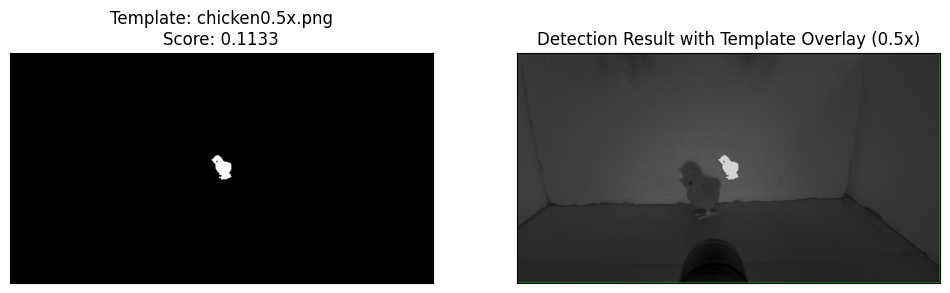

In [13]:
# แสดงผลสำหรับ chicken0.5x.png
result = template_results[0]
w, h = result['dimensions']
top_left = result['location']
bottom_right = (top_left[0] + w, top_left[1] + h)

# สร้างภาพ overlay
img_with_box = original_image_color.copy()
overlay = img_with_box.copy()
template_colored = cv2.cvtColor(result['template'], cv2.COLOR_GRAY2BGR)

# วางเทมเพลตลงบนตำแหน่งที่ match
overlay[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w] = template_colored

# ผสมภาพด้วย alpha blending
alpha = 0.5
img_with_overlay = cv2.addWeighted(overlay, alpha, img_with_box, 1-alpha, 0)

# วาดกรอบ
cv2.rectangle(img_with_overlay, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result['template'], cmap='gray')
plt.title(f"Template: {result['filename']}\nScore: {result['score']:.4f}")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_with_overlay, cv2.COLOR_BGR2RGB))
plt.title('Detection Result with Template Overlay (0.5x)')
plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
# แสดงผลสำหรับ chicken1.0x.png
result = template_results[1]
w, h = result['dimensions']
top_left = result['location']
bottom_right = (top_left[0] + w, top_left[1] + h)

img_with_box = original_image_color.copy()
overlay = img_with_box.copy()
template_colored = cv2.cvtColor(result['template'], cv2.COLOR_GRAY2BGR)

overlay[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w] = template_colored
img_with_overlay = cv2.addWeighted(overlay, alpha, img_with_box, 1-alpha, 0)
cv2.rectangle(img_with_overlay, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result['template'], cmap='gray')
plt.title(f"Template: {result['filename']}\nScore: {result['score']:.4f}")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_with_overlay, cv2.COLOR_BGR2RGB))
plt.title('Detection Result with Template Overlay (1.0x)')
plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'alpha' is not defined

In [7]:
# แสดงผลสำหรับ chicken2.0x.png
result = template_results[2]
w, h = result['dimensions']
top_left = result['location']
bottom_right = (top_left[0] + w, top_left[1] + h)

img_with_box = original_image_color.copy()
overlay = img_with_box.copy()
template_colored = cv2.cvtColor(result['template'], cv2.COLOR_GRAY2BGR)

overlay[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w] = template_colored
img_with_overlay = cv2.addWeighted(overlay, alpha, img_with_box, 1-alpha, 0)
cv2.rectangle(img_with_overlay, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result['template'], cmap='gray')
plt.title(f"Template: {result['filename']}\nScore: {result['score']:.4f}")
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_with_overlay, cv2.COLOR_BGR2RGB))
plt.title('Detection Result with Template Overlay (2.0x)')
plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'alpha' is not defined

พบการ match ทั้งหมด 0 ตำแหน่ง


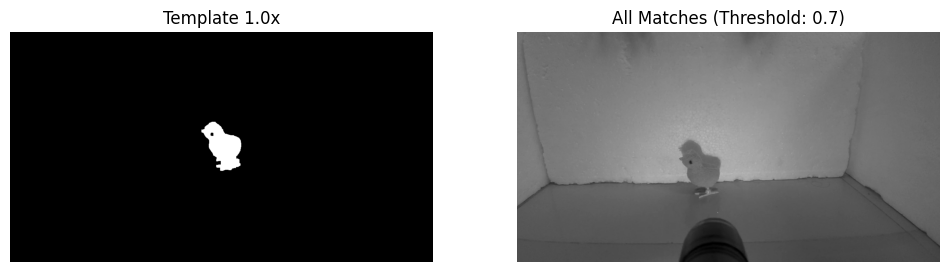

In [8]:
# ใช้เทมเพลต 1.0x (ที่ให้ผลดีที่สุด) ในการหาทุกตำแหน่งที่ match
best_template = cv2.imread('chicken1.0x.png', cv2.IMREAD_GRAYSCALE)
w, h = best_template.shape[::-1]

# ทำ template matching
result = cv2.matchTemplate(original_image, best_template, cv2.TM_CCOEFF_NORMED)

# กำหนด threshold สำหรับการ match (ปรับค่าตามความเหมาะสม)
threshold = 0.7
locations = np.where(result >= threshold)

# สร้างภาพผลลัพธ์
output_image = cv2.cvtColor(original_image.copy(), cv2.COLOR_GRAY2BGR)

# วาด bounding box ทุกตำแหน่งที่ match
for pt in zip(*locations[::-1]):  # กลับ y, x เป็น x, y
    # วาดกรอบสี่เหลี่ยม
    cv2.rectangle(output_image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

# แสดงผล
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(best_template, cmap='gray')
plt.title('Template 1.0x')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'All Matches (Threshold: {threshold})')
plt.axis('off')

print(f"พบการ match ทั้งหมด {len(locations[0])} ตำแหน่ง")
plt.show()

Object found - x:132, y:96, width:32, height:39, area:687.5


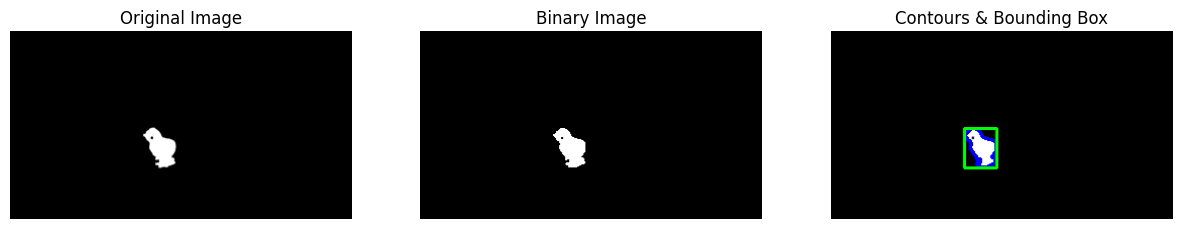

In [9]:
# อ่านภาพและแปลงเป็น binary image
image = cv2.imread('Chicken Edit 1.png', cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# หาคอนทัวร์ของวัตถุ
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# สร้างภาพผลลัพธ์
result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# วาดคอนทัวร์และบาวดิ้งบ็อกซ์สำหรับแต่ละวัตถุ
for contour in contours:
    # คำนวณบาวดิ้งบ็อกซ์
    x, y, w, h = cv2.boundingRect(contour)
    
    # คำนวณพื้นที่ของคอนทัวร์
    area = cv2.contourArea(contour)
    
    # กรองเฉพาะคอนทัวร์ที่มีขนาดใหญ่พอ (ตัดนอยส์ออก)
    if area > 100:  # ปรับค่าตามความเหมาะสม
        # วาดคอนทัวร์
        cv2.drawContours(result_image, [contour], -1, (255, 0, 0), 2)
        # วาดบาวดิ้งบ็อกซ์
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        print(f"Object found - x:{x}, y:{y}, width:{w}, height:{h}, area:{area}")

# แสดงผล
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Contours & Bounding Box')
plt.axis('off')

plt.show()